## Downloading dataset

In [ ]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

In [ ]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

In [ ]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

INFO:root:downloading & extracting file http://tennis-data.co.uk/2000/2000.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2001/2001.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2002/2002.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2003/2003.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2004/2004.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2005/2005.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2006/2006.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2007/2007.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2008/2008.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2009/2009.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2010/2010.zip
INFO:root:downloading & extracting file http://tennis-data.co.uk/2011/2011.zip
INFO:root:downloading & extracting file http://tenni

## Introduction

1) Exploring data
<br>
2) Answers to questions
<br>
3) Cleaning data
<br>
4) Comparing models to fit
<br>
5) Selecting best model and fitting
<br>
6) Conclusion


Here is my work on exploiting the dataset about ATP and WTA tennis matches. I had to predict the outcomes of matches played in 2017 and answer some questions.
<br>
After exploring the data, I answered the questions. Then I cleaned the data, fitted some models to see the most promising one. After that, I fitted the best model and predicted the outcomes of the matches.
<br>
The main can be found at the bottom of the notebook.

## Imports

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
!pip install jcopml
from jcopml.plot import plot_missing_value

import random
import math
from tqdm import trange

from sklearn.preprocessing import scale
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from time import time
import pickle
import csv

from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 102kB 6.0MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.10-py2.py3-none-any.whl size=33232 sha256=57b6540c5730104971282182c9fea11781d0a081eb49e1e052109793abe64690
  Stored in directory: /root/.cache/pip/wheels/82/22/ce/b8b4c3400f788e5050b5b4b4d988884b8ec72b6b8751693914
Successfully built jcopml


## Feature Exploration

I first get some general information regarding the datasets like the dimensions, the head and tail, the description of the columns, the numerical and categorical columns, the distribution of the null values and the correlation matrix. I also look at all the unique values per column, their number and the type of the data per column to get a good idea of the data I will be dealing with. The scatter matrix has not been plotted since there are too many columns, it takes too much time to plot.

In [ ]:
df_atp = pd.read_csv("atp.csv")
# df_wta = pd.read_csv("wta.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13,16,17,18,19,25,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
def general_info(df):
    
    """
    Gives general information:
    - dimensions
    - head and tail
    - description
    - numerical and categorical columns
    - null values distribution
    - null values per column
    - correlation matrix to have a more mathematical insight
    """

    # dimensions
    print("Dimensions :", df.shape)

    # head and tail
    print('\n', "Head :")
    display(df.head())
    print('\n', "Tail :")
    display(df.tail())

    # description of the columns
    print('\n', "Description :")
    display(df.describe())

    # numerical and categorical data
    num, cat = num_cat(df)

    # null values per column and their distribution
    print('\n', "Null values distribution :")
    display(plot_missing_value(df, return_df=True).sort_values("missing_value", ascending=False))
    
    # correlation heatmap
    print('\n', "Correlation matrix :")
    correlation_heatmap(df)

    all_info(df)    


In [ ]:
def num_cat(df):

    """Returns a list of the numerical and categorical columns."""
    
    numeric_features = df.select_dtypes(include = [np.number])
    num = numeric_features.columns.tolist()
    print('\n', "Numerical columns : ")
    print(num, '\n')
    categorical_features = df.select_dtypes(include = [np.object])

    cat = categorical_features.columns.tolist()
    print("Categorical columns : ")
    print(cat, '\n')
    return num, cat

    
def correlation_heatmap(df):

    """Returns the correlation matrix."""

    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(50,50))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}, annot_kws={'size':25})
    plt.show()


def all_info(df):

    """
    For every column, prints :
    - its name
    - the number of unique values
    - all the unique values
    - the type of each column
    """
    print('\n', "Number of unique values and values, type of each column :")
    for i in df.columns:
        print("COLONNE :", i, len(df[i].unique()), df[i].unique(), df[i].dtypes, '\n')

General information about the ATP dataset 

Dimensions : (52298, 55)

 Head :


,Unnamed: 0,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
0,0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,6.0,4.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Enqvist T.,Clement A.,5,56,6.0,3.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Escude N.,Baccanello P.,40,655,6.0,7.0,7,5,6.0,3,NaN,NaN,NaN,NaN,2.0,1,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Federer R.,Knippschild J.,65,87,6.0,1.0,6,4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Fromberg R.,Woodbridge T.,81,198,7.0,6.0,5,7,6.0,4,NaN,NaN,NaN,NaN,2.0,1,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 Tail :


,Unnamed: 0,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
52293,52293,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,Isner J.,5,10,7.0,6.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36,3.20,NaN,NaN,1.38,3.40,1.40,3.22,5085.0,3155.0,NaN,NaN,NaN,NaN,NaN,NaN,1.44,3.40,1.38,3.14
52294,52294,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,Cilic M.,1,7,7.0,6.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,4.50,NaN,NaN,1.19,5.50,1.20,5.23,8045.0,4050.0,NaN,NaN,NaN,NaN,NaN,NaN,1.22,6.03,1.17,5.14
52295,52295,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Zverev A.,Federer R.,5,3,7.0,5.0,7,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.20,1.36,NaN,NaN,3.2,1.42,3.24,1.41,5085.0,6020.0,NaN,NaN,NaN,NaN,NaN,NaN,3.40,1.45,3.14,1.38
52296,52296,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Djokovic N.,Anderson K.,1,6,6.0,2.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,7.00,NaN,NaN,1.14,7.00,1.12,7.72,8045.0,4310.0,NaN,NaN,NaN,NaN,NaN,NaN,1.15,7.72,1.12,6.52
52297,52297,67,London,Masters Cup,2018-11-18,Masters Cup,Indoor,Hard,The Final,3,Zverev A.,Djokovic N.,5,1,6.0,4.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.50,1.14,NaN,NaN,6,1.17,6.36,1.16,5085.0,8045.0,NaN,NaN,NaN,NaN,NaN,NaN,6.36,1.22,5.69,1.15



 Description :


,Unnamed: 0,ATP,Best of,W1,L1,W4,L4,W5,L5,Wsets,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL
count,52298.000000,52298.000000,52298.000000,52035.000000,52037.000000,4731.000000,4731.000000,1791.000000,1791.000000,52074.000000,17506.000000,17506.000000,5055.000000,5055.000000,13358.000000,13358.000000,5424.000000,5424.000000,43643.000000,43666.000000,1097.000000,1097.000000,39416.000000,37339.000000,37339.000000,36094.000000,36035.000000,10671.000000,10671.000000,28131.000000,28142.000000,15572.000000,15579.000000,22745.000000,22745.000000,22745.000000,22745.000000
mean,26148.500000,33.222532,3.372366,5.794331,4.056229,5.777003,3.863454,6.637633,3.756002,2.141760,1.812080,3.000658,1.738742,2.401363,1.671585,2.387132,1.793035,2.672064,1.823768,3.551805,1.728633,2.547347,3.262180,1.926742,4.186818,1831.891644,1047.544665,1.815867,3.542479,1.810226,3.451461,1.796538,3.557943,1.998610,8.326076,1.834821,3.594448
std,15097.276526,18.115493,0.778516,1.239577,1.845206,1.274712,1.895683,2.290596,2.817183,0.460311,0.868254,2.032791,0.614454,1.057305,0.585400,1.048818,0.751026,1.424672,1.100806,3.527564,0.730434,1.330386,2.449627,1.334797,5.581127,2294.307489,1213.773168,0.996238,3.646316,1.031691,3.075889,1.004273,3.272510,1.628982,397.235666,1.107884,3.282610
min,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.020000,1.010000,1.030000,1.010000,1.030000,0.000000,0.000000,1.000000,1.002000,1.010000,1.020000,1.000000,1.000000,1.010000,1.000000,1.000000,1.010000,1.020000,1.000000,1.000000,1.000000,1.010000,1.010000,1.010000,1.010000,1.010000
25%,13074.250000,19.000000,3.000000,6.000000,3.000000,6.000000,2.000000,6.000000,2.000000,2.000000,1.280000,1.720000,1.330000,1.655000,1.300000,1.650000,1.333000,1.670000,1.222000,1.720000,1.250000,1.600000,1.750000,1.270000,1.794000,640.000000,496.000000,1.240000,1.750000,1.250000,1.730000,1.220000,1.730000,1.290000,1.850000,1.240000,1.740000
50%,26148.500000,33.000000,3.000000,6.000000,4.000000,6.000000,4.000000,6.000000,3.000000,2.000000,1.550000,2.375000,1.550000,2.100000,1.500000,2.100000,1.571000,2.250000,1.500000,2.500000,1.500000,2.150000,2.460000,1.550000,2.660000,1007.000000,736.000000,1.500000,2.500000,1.500000,2.500000,1.500000,2.630000,1.570000,2.780000,1.500000,2.550000
75%,39222.750000,49.000000,3.000000,6.000000,6.000000,6.000000,6.000000,7.000000,5.000000,2.000000,2.050000,3.400000,1.980000,2.800000,1.850000,2.900000,2.100000,3.000000,2.075000,4.000000,1.950000,3.100000,3.750000,2.140000,4.240000,1895.000000,1141.000000,2.030000,3.850000,2.000000,4.000000,2.000000,4.000000,2.200000,4.540000,2.060000,3.990000
max,52297.000000,69.000000,5.000000,7.000000,7.000000,7.000000,7.000000,70.000000,68.000000,3.000000,14.000000,25.000000,7.500000,11.000000,6.000000,10.000000,9.000000,13.000000,29.000000,101.000000,7.500000,9.000000,40.000000,46.000000,121.000000,16950.000000,16950.000000,18.000000,60.000000,26.000000,51.000000,19.000000,81.000000,76.000000,42586.000000,23.450000,36.440000



 Numerical columns : 
['Unnamed: 0', 'ATP', 'Best of', 'W1', 'L1', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'CBW', 'CBL', 'GBW', 'GBL', 'IWW', 'IWL', 'SBW', 'SBL', 'B365W', 'B365L', 'B&WW', 'B&WL', 'EXL', 'PSW', 'PSL', 'WPts', 'LPts', 'UBW', 'UBL', 'LBW', 'LBL', 'SJW', 'SJL', 'MaxW', 'MaxL', 'AvgW', 'AvgL'] 

Categorical columns : 
['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Winner', 'Loser', 'WRank', 'LRank', 'W2', 'L2', 'W3', 'L3', 'Lsets', 'Comment', 'EXW'] 


 Null values distribution :


,missing_value,%
B&WW,51201,97.90
B&WL,51201,97.90
W5,50507,96.58
L5,50507,96.58
L4,47567,90.95
W4,47567,90.95
GBL,47243,90.33
GBW,47243,90.33
SBL,46874,89.63
SBW,46874,89.63



 Correlation matrix :


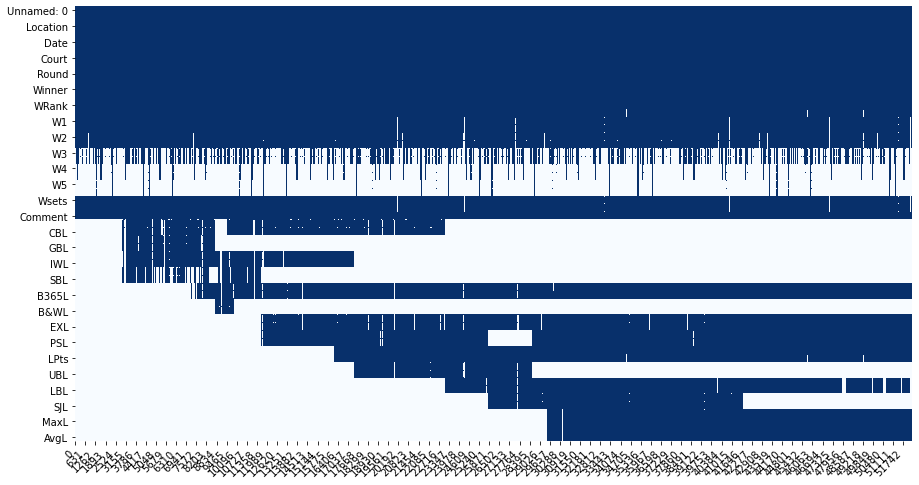

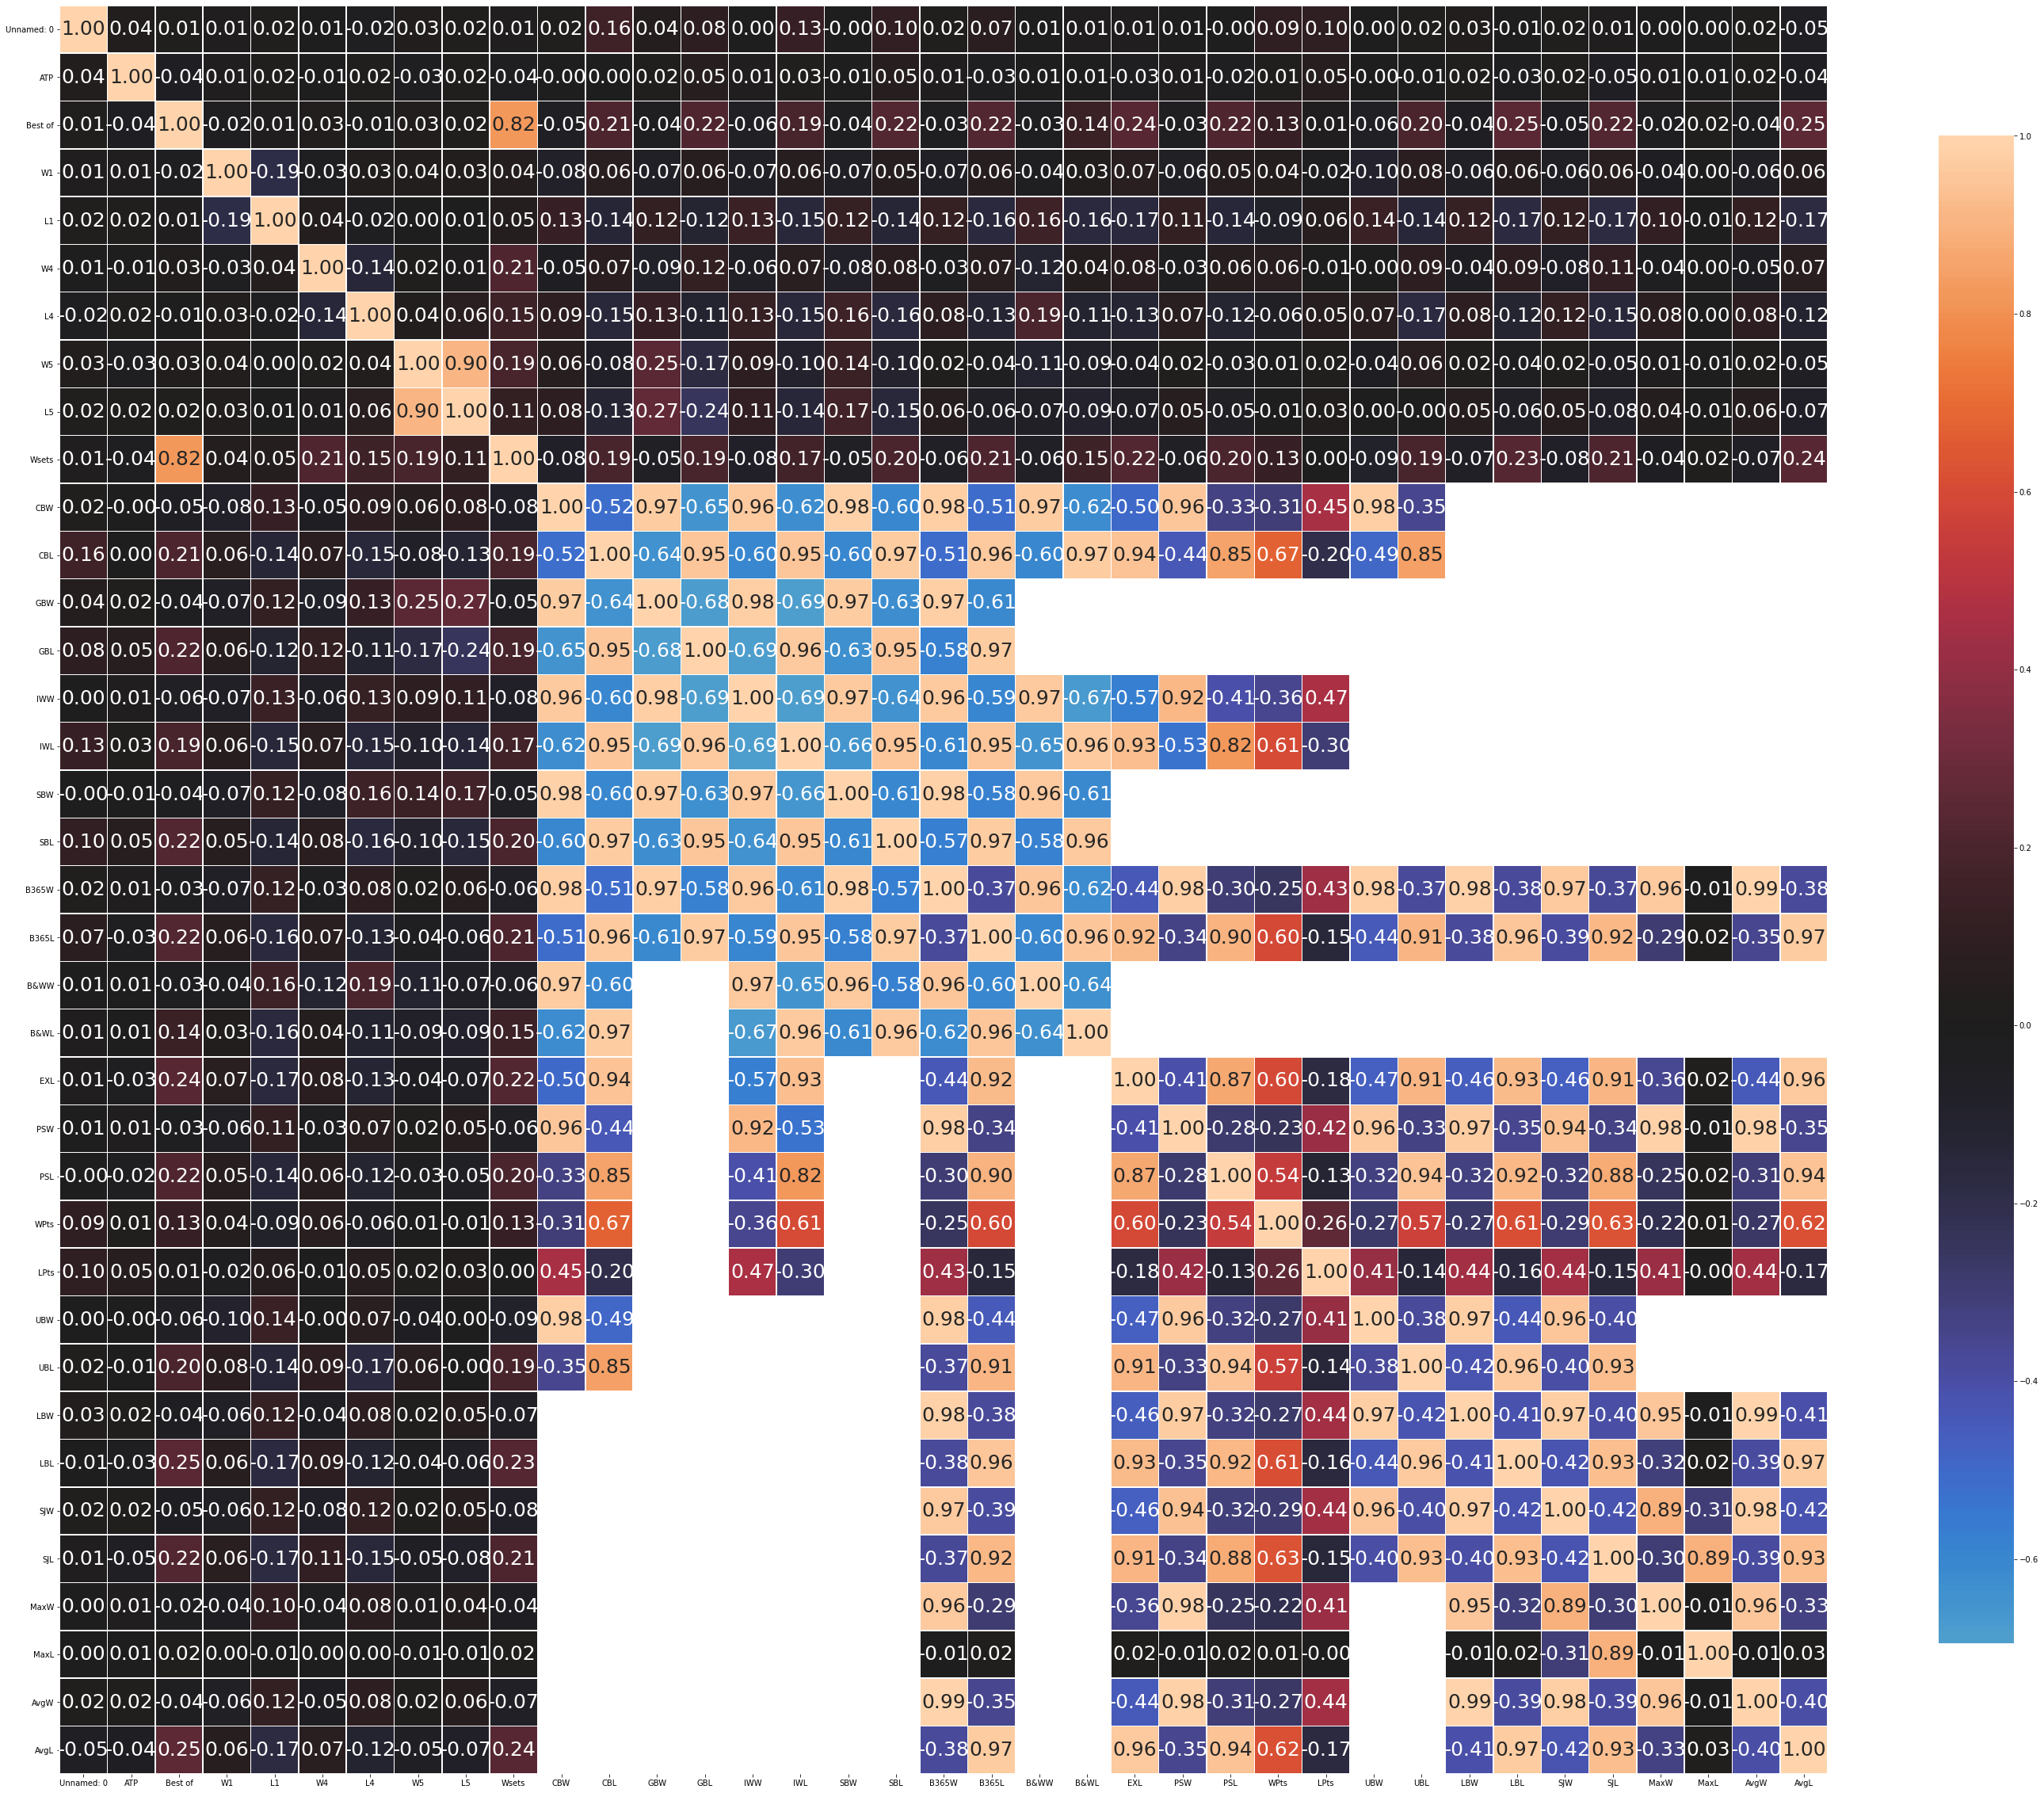


 Number of unique values and values, type of each column :
COLONNE : Unnamed: 0 52298 [    0     1     2 ... 52295 52296 52297] int64 

COLONNE : ATP 69 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69] int64 

COLONNE : Location 115 ['Adelaide' 'Chennai' 'Doha' 'Auckland' 'Sydney' 'Melbourne' 'Dubai'
 'Marseille' 'San Jose' 'Memphis' 'Rotterdam' 'London' 'Mexico City'
 'Copenhagen' 'Delray Beach' 'Santiago' 'Bogota' 'Scottsdale'
 'Indian Wells' 'Miami' 'Atlanta' 'Casablanca' 'Estoril' 'Monte Carlo'
 'Barcelona' 'Mallorca' 'Munich' 'Orlando' 'Rome' 'Hamburg' 'St. Polten'
 'Paris' 'Halle' 'Queens Club' 'Nottingham' "'s-Hertogenbosch" 'Bastad'
 'Gstaad' 'Newport' 'Amsterdam' 'Stuttgart' 'Umag' 'Kitzbuhel'
 'Los Angeles' 'San Marino' 'Toronto' 'Cincinnati' 'Indianapolis'
 'Washington' 'Long Island' 'New York' 'Bucharest' 'Tashken

In [ ]:
# general information
print("General information about the ATP dataset", '\n')
general_info(df_atp)

In [ ]:
# general information
# print("General information about the WTA dataset", '\n')
# general_info(df_wta)

After having this insight of the datasets, I can conclude that some work regarding the odds is needed to fill in the missing values and that there is no direct way of predicting the winner.

## Answer to questions

In [ ]:
df_atp_questions = pd.read_csv("atp.csv")
df_wta_questions = pd.read_csv("wta.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12,13,16,17,18,19,25,39) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (26,29,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Question 1 : Who are the three ATP players with the most wins ?

# I first group the data by the winner's name and count how many times each one appear
winner_count = df_atp_questions.groupby(['Winner']).count()
# Then I sort them by descending order and take the 3 first
winner_count.sort_values(by="ATP", ascending=False, inplace=True)

print("Question 1 : Who are the three ATP players with the most wins ?")
print("The three ATP players with most wins are : {}, {} and {}".format(winner_count.index[0],
                                                                     winner_count.index[1],
                                                                     winner_count.index[2]), '\n')


# Question 2 : How many sets did the player “ Federer R.” win in total ?

# I need to prepare the data
df_atp_questions['Lsets'].replace('`1', 1, inplace=True)
df_atp_questions = df_atp_questions.astype({'Lsets': float})

# I sum on both the sets where Federer won and lost
roger = df_atp_questions[df_atp_questions['Winner'] == "Federer R."]['Wsets'].sum() + \
        df_atp_questions[df_atp_questions['Loser'] == "Federer R."]['Lsets'].sum()

print("Question 2 : How many sets did the player “ Federer R.” win in total ?")
print("Federer won {} sets in total.".format(roger), '\n')


# Question 3 : How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?

# I do the same as previously but take care to limit the data to 2016 and 2017
df_atp_questions['Date'] = pd.to_datetime(df_atp_questions['Date'])
df_atp_questions['Year'] = [d.date().year for d in df_atp_questions['Date']]
df_atp_questions_1617 = pd.concat([df_atp_questions[df_atp_questions['Year'] == 2016], df_atp_questions[df_atp_questions['Year'] == 2017]])
roger1617 = df_atp_questions_1617[df_atp_questions_1617['Winner'] == "Federer R."]['Wsets'].sum() + df_atp_questions_1617[df_atp_questions_1617['Loser'] == "Federer R."]['Lsets'].sum()

print("Question 3 : How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?")
print("Federer won {} sets in total in 2016 and 2017.".format(roger1617), '\n')


# Question 4 : For each match, what is the percentage of victories of the winner in the past ?

print("Question 4 : For each match, what is the percentage of victories of the winner in the past ?")

# First for the ATP tournaments:

df_atp_questions_victory = df_atp_questions.copy()
df_atp_questions_victory['Victory_%'] = 0.0 # creating the percentage of victories column

win_atp = {}    # keeps track of the number of wins for each player
total_atp = {}  # keeps track of the total number of matches for each player

for i in range(len(df_atp_questions_victory)):
    winner = df_atp_questions_victory['Winner'].iloc[i]   # retrieving the winner's name
    win_atp[winner] = win_atp.get(winner, 0) + 1
    loser = df_atp_questions_victory['Loser'].iloc[i]     # retrieving the loser's name
    total_atp[winner] = total_atp.get(winner, 0) + 1
    total_atp[loser] = total_atp.get(loser, 0) + 1

    # constructing the percentage by dividing the number of wins by the total number of matches played
    df_atp_questions_victory.loc[i, 'Victory_%'] = round(win_atp[winner] / total_atp[winner] * 100, 2)

# displaying the tail to see if the output is relevent
print("For ATP :", '\n')
display(df_atp_questions_victory.tail())

# As the question didn't explicitly mentionned the ATP dataset, I did the same for the WTA one.
# Then for the WTA tournaments:

df_wta_questions_victory = df_wta_questions.copy()
df_wta_questions_victory['Victory_%'] = 0.0 # creating the percentage of victories column
win_wta = {}    # keeps track of the number of wins for each player
total_wta = {}  # keeps track of the total number of matches for each player

for i in range(len(df_wta_questions_victory)):
    winner = df_wta_questions_victory['Winner'].iloc[i]   # retrieving the winner's name
    win_wta[winner] = win_wta.get(winner, 0) + 1
    loser = df_wta_questions_victory['Loser'].iloc[i]     # retrieving the loser's name
    total_wta[winner] = total_wta.get(winner, 0) + 1
    total_wta[loser] = total_wta.get(loser, 0) + 1

    # constructing the percentage by dividing the number of wins by the total number of matches played
    df_wta_questions_victory.loc[i, 'Victory_%'] = round(win_wta[winner] / total_wta[winner] * 100, 2)

# displaying the tail to see if the output is relevent
print('\n', "For WTA :", '\n')
display(df_wta_questions_victory.tail())

Question 1 : Who are the three ATP players with the most wins ?
The three ATP players with most wins are : Federer R., Nadal R. and Djokovic N. 

Question 2 : How many sets did the player “ Federer R.” win in total ?
Federer won 2696.0 sets in total. 

Question 3 : How many sets did the player “ Federer R.” win during the years 2016 and 2017 ?
Federer won 182.0 sets in total in 2016 and 2017. 

Question 4 : For each match, what is the percentage of victories of the winner in the past ?
For ATP : 



,Unnamed: 0,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,W1,L1,W2,L2,W3,L3,W4,L4,W5,L5,Wsets,Lsets,Comment,CBW,CBL,GBW,GBL,IWW,IWL,SBW,SBL,B365W,B365L,B&WW,B&WL,EXW,EXL,PSW,PSL,WPts,LPts,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,Year,Victory_%
52293,52293,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Zverev A.,Isner J.,5,10,7.0,6.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36,3.20,NaN,NaN,1.38,3.40,1.40,3.22,5085.0,3155.0,NaN,NaN,NaN,NaN,NaN,NaN,1.44,3.40,1.38,3.14,2018,66.54
52294,52294,67,London,Masters Cup,2018-11-16,Masters Cup,Indoor,Hard,Round Robin,3,Djokovic N.,Cilic M.,1,7,7.0,6.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,4.50,NaN,NaN,1.19,5.50,1.20,5.23,8045.0,4050.0,NaN,NaN,NaN,NaN,NaN,NaN,1.22,6.03,1.17,5.14,2018,83.01
52295,52295,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Zverev A.,Federer R.,5,3,7.0,5.0,7,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.20,1.36,NaN,NaN,3.2,1.42,3.24,1.41,5085.0,6020.0,NaN,NaN,NaN,NaN,NaN,NaN,3.40,1.45,3.14,1.38,2018,66.67
52296,52296,67,London,Masters Cup,2018-11-17,Masters Cup,Indoor,Hard,Semifinals,3,Djokovic N.,Anderson K.,1,6,6.0,2.0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,7.00,NaN,NaN,1.14,7.00,1.12,7.72,8045.0,4310.0,NaN,NaN,NaN,NaN,NaN,NaN,1.15,7.72,1.12,6.52,2018,83.02
52297,52297,67,London,Masters Cup,2018-11-18,Masters Cup,Indoor,Hard,The Final,3,Zverev A.,Djokovic N.,5,1,6.0,4.0,6,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,Completed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.50,1.14,NaN,NaN,6,1.17,6.36,1.16,5085.0,8045.0,NaN,NaN,NaN,NaN,NaN,NaN,6.36,1.22,5.69,1.15,2018,66.8



 For WTA : 



,Unnamed: 0,WTA,Location,Tournament,Date,Tier,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,WPts,LPts,W1,L1,W2,L2,W3,L3,Wsets,Lsets,Comment,B365W,B365L,CBW,CBL,EXW,EXL,PSW,PSL,UBW,UBL,LBW,LBL,SJW,SJL,MaxW,MaxL,AvgW,AvgL,Victory_%
29576,29576,59,Zhuhai,WTA Elite Trophy,2018-11-02,Tour Championships,Indoor,Hard,Round Robin,3,Muguruza G.,Sevastova A.,17.0,11.0,2725.0,3185.0,6.0,7.0,6.0,2.0,7.0,6.0,2.0,1.0,Completed,1.72,2,NaN,NaN,1.9,2.00,1.93,1.97,NaN,NaN,NaN,NaN,NaN,NaN,2.05,2.06,1.88,1.95,63.61
29577,29577,59,Zhuhai,WTA Elite Trophy,2018-11-02,Tour Championships,Indoor,Hard,Round Robin,3,Wang Q.,Keys M.,22.0,16.0,2155.0,2817.0,1.0,6.0,6.0,3.0,6.0,1.0,2.0,1.0,Completed,2.37,1.53,NaN,NaN,2.45,1.60,2.38,1.66,NaN,NaN,NaN,NaN,NaN,NaN,2.55,1.66,2.41,1.58,51.72
29578,29578,59,Zhuhai,WTA Elite Trophy,2018-11-03,Tour Championships,Indoor,Hard,Semifinals,3,Barty A.,Goerges J.,19.0,14.0,2420.0,2995.0,4.0,6.0,6.0,3.0,6.0,2.0,2.0,1.0,Completed,1.90,1.9,NaN,NaN,1.95,1.95,2.00,1.93,NaN,NaN,NaN,NaN,NaN,NaN,2.10,1.95,1.96,1.87,61.42
29579,29579,59,Zhuhai,WTA Elite Trophy,2018-11-03,Tour Championships,Indoor,Hard,Semifinals,3,Wang Q.,Muguruza G.,22.0,17.0,2155.0,2725.0,6.0,2.0,6.0,0.0,NaN,NaN,2.0,0.0,Completed,2.20,1.66,NaN,NaN,2.25,1.70,2.28,1.72,NaN,NaN,NaN,NaN,NaN,NaN,2.45,1.72,2.25,1.67,52.05
29580,29580,59,Zhuhai,WTA Elite Trophy,2018-11-04,Tour Championships,Indoor,Hard,The Final,3,Barty A.,Wang Q.,19.0,22.0,2420.0,2155.0,6.0,3.0,6.0,4.0,NaN,NaN,2.0,0.0,Completed,2.00,1.8,NaN,NaN,2.05,1.85,2.11,1.83,NaN,NaN,NaN,NaN,NaN,NaN,2.11,1.90,2.03,1.82,61.72


## Feature Cleaning

To predict the winner, I will focus on the odds, the percentage of victory, the rank and the experience which is the total number of matches played. I will drop the results of the match, including the number of points and sets won per match as it would be considered cheating to use these data. The same will be applied to the year 2018 to predict the results of the year 2017 : knowing the results of 2018 might make the prediction of year 2017 easier than what it would really be.

I first create the percentage of victory and experience columns.

In [ ]:
def victory_percentage(df):
    
    """Returns the percentage of victories and the experience of the players."""
    
    # creating the columns
    df['Victory_%W'] = 0.0
    df['Victory_%L'] = 0.0
    df['Total_Match_Won_W'] = 0
    df['Total_Match_Won_L'] = 0
    df['Total_Match_Lost_W'] = 0
    df['Total_Match_Lost_L'] = 0

    win = {}    # keeps track of the number of wins for each player
    loss = {}    # keeps track of the number of losses for each player
    total = {}  # keeps track of the total number of matches for each player
    for i in trange(len(df)):
        winner = df['Winner'].iloc[i]
        loser = df['Loser'].iloc[i]
        win[winner] = win.get(winner, 0) + 1
        win[loser] = win.get(loser, 0) + 0
        loss[winner] = loss.get(winner, 0) + 0
        loss[loser] = loss.get(loser, 0) + 1
        total[winner] = total.get(winner, 0) + 1
        total[loser] = total.get(loser, 0) + 1

        # updating the percentage of victory and experience for each player
        df.loc[i, 'Victory_%W'] = round(win[winner] / total[winner] * 100, 5)
        df.loc[i, 'Victory_%L'] = round(win[loser] / total[loser] * 100, 5)
        df.loc[i, 'Total_Match_Won_W'] = win[winner]
        df.loc[i, 'Total_Match_Won_L'] = win[loser]
        df.loc[i, 'Total_Match_Lost_W'] = loss[winner]
        df.loc[i, 'Total_Match_Lost_L'] = loss[loser]
    
    return df

In [ ]:
# def total_match_won_and_lost(df):

#     matches_won = df.groupby('Winner').count()
#     df.loc[:, 'Total_Match_won'] = df['Winner'].map(mean_encode)

In [ ]:
# def player_mean_encoding(df):

#     """Mean encoding of the players' name."""

#     mean_encode = df.groupby('Winner')['Victory_%W'].mean()
#     df.loc[:, 'Winner_mean_encoding'] = df['Winner'].map(mean_encode)
#     mean_encode = df.groupby('Loser')['Victory_%L'].mean()
#     df.loc[:, 'Loser_mean_encoding'] = df['Loser'].map(mean_encode)

#     return df

Now, I will transform the dataset to be able to predict the winner. To do so, I will randomly seperate the winners and losers into player 1 and player 2. This means that the winner can either be player 1 or player 2. All the considered data (odds, ranks, victory percentage and total played matches) will be assigned to player 1 or player 2, according to the previous random allocation.
<br>
To keep track of the winner, the column "winner" will be filled with ones only when player 1 actually wins, otherwise, it will be filled by zeros if the winner is player 2. In order to retrieve the names of the winners and losers, their real names as well as the value in the "winner" column will be saved in another dataset called winner.

Here is a quick example:
<br>
Winner : Federer R.
<br>
WRank : 4
<br><br>
Loser : Djokovic N.
<br>
LRank : 1
<br>
<br>
Let's imagine Federer is randomly assigned to player 2. Then, P2Rank will be equal to 4 and P1Rank will be assigned 1. In the new "winner" column, the value associated would be 0 as player 2 is the winner of the match.
<br>

In [ ]:
def to_p1_p2(df, columns_p1, columns_p2, new_columns_p1, new_columns_p2):
    
    """
    Transforming df into P1 and P2,
    constructing side dataframe with corresponding winner/loser.
    """
    
    len_new_columns = len(new_columns_p1)

    # winner keeps track of the winners and losers 
    winner = df[['Winner', 'Loser']].copy()
    winner['Num_winner'] = 0

    # creating the new Winner column
    df.drop(['Winner', 'Loser'], inplace=True, axis=1)
    df['Winner'] = 0

    # creating new columns that will receive the players' data
    for i in range(len_new_columns):
        df[new_columns_p1[i]] = 0
        df[new_columns_p2[i]] = 0

    random.seed(10)
    for i in trange(len(df)):

        # winner is assigned to player 1
        if random.random() > 0.5:
            for j in range(len_new_columns):
                df.loc[i, new_columns_p1[j]] = df[columns_p1[j]].iloc[i]
                df.loc[i, new_columns_p2[j]] = df[columns_p2[j]].iloc[i]
            df.loc[i, 'Winner'] = 1
            winner.loc[i, 'Num_winner'] = 1     # keep track of the player who won
        
        # winner is assigned to player 2
        else:
            for j in range(len_new_columns):
                df.loc[i, new_columns_p1[j]] = df[columns_p2[j]].iloc[i]
                df.loc[i, new_columns_p2[j]] = df[columns_p1[j]].iloc[i]
            df.loc[i, 'Winner'] = 0
            winner.loc[i, 'Num_winner'] = 0     # keep track of the player who won

    # dropping the old winner/loser columns
    df.drop(columns_p1 + columns_p2, inplace=True, axis=1)
    
    # displaying the head to see if the output is relevent
    print('\n', "Conversion to P1 and P2 columns finished, printing the head of the dataset :", '\n')
    print('\n', "Head printing", '\n')
    display(df.head())
    print('\n', "Tail printing", '\n')
    display(df.tail())

    return df, winner

I now make an average of all the odds and fill in the missing data for the max and average odd columns.

In [ ]:
def average_odds(df, odds_p1, odds_p2):

    """
    Averaging all odds to counter the missing data problem
    and exploit every odd available
    Replacing missing values by 1 for both P1 and P2
    """
    
    for i in trange(len(df)):

        # calculating the means of odds for each player and each match
        a = df[odds_p1].iloc[i].mean() / df[odds_p1].iloc[i].count()
        b = df[odds_p2].iloc[i].mean() / df[odds_p2].iloc[i].count()

        # all the odds of player 1 are na
        if math.isnan(a):
            df.loc[i, 'AvgP1'] = 1
        else:
            df.loc[i, 'AvgP1'] = a
        
        # all the odds of player 2 are na
        if math.isnan(b):
            df.loc[i, 'AvgP2'] = 1
        else:
            df.loc[i, 'AvgP2'] = b

        # trying to fill in the missing values for max and average odds
        if np.isnan(df['MaxP1'].iloc[i]):
            temp_max = df.loc[i, odds_p1].max()
            df.loc[i, 'MaxP1'] = temp_max if not np.isnan(temp_max) else 1
        if np.isnan(df['MaxP2'].iloc[i]):
            temp_max = df.loc[i, odds_p2].max()
            df.loc[i, 'MaxP2'] = temp_max if not np.isnan(temp_max) else 1

    # Dropping odds columns
    odds_p1.remove('AvgP1')
    odds_p2.remove('AvgP2')
    df.drop(columns=odds_p1 + odds_p2, inplace=True, axis=1)

    return df

Here are several functions used to clean the data. There are :
- the handling of more missing values not in the odds columns
- the transformation of the columns to the float type
- the separation of the Date column into Year, Month and Day columns
- the scaling of the numerical data so that they have the same weight for the models' fitting

In [ ]:
def cleaning(df, to_drop):
    
    """
    Returns a version of the dataframe without the to_drop columns
    and with relevent columns transformed to float type.
    """

    # dropping useless columns
    df.drop(columns=to_drop, inplace=True, axis=1)
    
    # replacing players' rank with no rank by the worst rank 
    # rounded to the next hundred
    df['WRank'].replace('NR', 0, inplace=True)
    df['LRank'].replace('NR', 0, inplace=True)
    df = to_float(df, ['WRank', 'LRank'])
    
    max_rank = max(math.ceil(df['WRank'].max()/100)*100, math.ceil(df['LRank'].max()/100)*100)

    df['WRank'].replace(0, max_rank, inplace=True)
    df['LRank'].replace(0, max_rank, inplace=True)

    # replacing some wild unexpected values
    df['B365L'].replace('5..5', 5.5, inplace=True)
    df['EXW'].replace(' ', np.nan, inplace=True)
    df['LBW'].replace(' ', np.nan, inplace=True)
    df['LBW'].replace('2,25', 2.25, inplace=True)
    df['EXW'].replace('2.,3', 2.3, inplace=True)
    df['EXL'].replace('2.,3', 2.3, inplace=True)

    # filling the missing values with the rounded worst rank
    for column in ['WRank', 'LRank']:
        df[column].fillna(max_rank, inplace=True)
    
    # converting columns to float type
    df = to_float(df, ['B365L', 'EXW', 'LBW'])
    
    return df

def fill_in_missing_value(df):

    """
    Fills in the missing WPts and LPts values with the first non null values
    or the mean of the non null values.
    Fills in possible missing values of column Date.
    """

    df['WPts']=df.groupby('Winner')['WPts'].apply(lambda x : x.fillna(method='bfill').fillna(method='ffill'))
    df['WPts']=df.groupby('Loser')['WPts'].apply(lambda x : x.fillna(method='bfill').fillna(method='ffill'))
    df['LPts']=df.groupby('Loser')['LPts'].apply(lambda x : x.fillna(method='bfill').fillna(method='ffill'))
    df['LPts']=df.groupby('Winner')['LPts'].apply(lambda x : x.fillna(method='bfill').fillna(method='ffill'))

    # filling in the missing values with the means
    df['LPts'].fillna(df['LPts'].mean(), inplace=True)
    df['WPts'].fillna(df['WPts'].mean(), inplace=True)
    df['Date'].fillna(method='bfill', inplace=True)

    return df
    
# Dropping old columns

def to_float(df, columns):

    """Transforms columns' data into float type"""

    for column in columns:
        try:
            df = df.astype({column: float})
        except Exception as e:
            print(column)
            print(e)
            pass

    return df
    
# Date cleaning
def date_cleaning(df):

    """
    Seperates Date column into Year, Month and Day 
    then transforms to one-hot encoding.
    """

    # seperating Date into Year, Month and Day columns
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = [d.date().year for d in df['Date']]
    df['Month'] = [d.date().month for d in df['Date']]
    df['Day'] = [d.date().day for d in df['Date']]

    # dropping Date column
    df.drop(columns="Date", inplace=True)
    
    # one-hot encoding
    for column in ['Year', 'Month', 'Day']:
        df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], prefix=column)], axis=1)

    return df


def final_cleaning(df):

    """I don't know why I need to drop these random wild columns sometimes..."""

    columns=['Unnamed: 0',	'Unnamed: 0.1',	'Unnamed: 0.1.1', 
             'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1']

    for column in columns:
        try:
            df.drop(column, axis=1, inplace=True)
        except:
            pass

    return df

def to_scale(df):

    """Centers to the mean and component wise scale to unit variance."""
        
    cols = [['Victory_%P1', 'Victory_%P2', 
             'P1Rank', 'P2Rank',
             'P1Pts', 'P2Pts', 
             'MaxP1', 'MaxP2', 
             'AvgP1', 'AvgP2', 
             'Total_Match_Won_P1', 'Total_Match_Won_P2',
             'Total_Match_Lost_P1', 'Total_Match_Lost_P2']]

    for col in cols:
        df[col] = scale(df[col])
        
    return df

def drop_date(df_train, df_2017):

    """Dropping date columns after splitting into train, test and 2017 datasets."""

    to_drop = ['Year_2000', 'Year_2001', 'Year_2002', 'Year_2003', 'Year_2004', 
               'Year_2005', 'Year_2006', 'Year_2007', 'Year_2008', 'Year_2009', 
               'Year_2010', 'Year_2011', 'Year_2012', 'Year_2013', 'Year_2014', 
               'Year_2015', 'Year_2016', 'Year_2017', 'Year_2018',
               'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 
               'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12',
               'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 
               'Day_8', 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 
               'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 
               'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 
               'Day_29', 'Day_30', 'Day_31']
    for column in to_drop:
        try:
            df_train.drop(column, axis=1, inplace=True)
            df_2017.drop(column, axis=1, inplace=True)
        except:
            pass
    
    return df_train, df_2017
    

## Fitting the models

In [ ]:
def split_train_2017(df):

    """Splitting data between 2017 dataset and other years without 2018."""
    
    df_2017 = df[df['Year_2017'] == 1]
    df_train = df[df['Year_2017'] != 1]
    df_train = df_train[df_train['Year_2018'] != 1]

    return df_train, df_2017
    

def split_train_test(df_train, df_2017):
    
    """Splitting data between training and testing datasets."""

    X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['Winner']), df_train['Winner'], test_size=0.2, random_state=42)
    df_2017_X = df_2017.drop(columns="Winner", axis=1)
    df_2017_Y = df_2017['Winner']

    return X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), df_2017_X.to_numpy(), df_2017_Y.to_numpy()

Training and fitting functions

In [ ]:
def predict_labels(clf, features, target):
    
    """Predicts using a fit classifier based on F1 score."""
    
    y_pred = clf.predict(features)
    
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred)), y_pred


def train_predict(clf, X_train, y_train, X_test, y_test):
    
    """Calls training and predicting functions."""
        
    # Indicate the classifier and the training set size
    print('\n', "Training a {}.".format(clf.__class__.__name__))
    
    # Training
    clf.fit(X_train, y_train)

    # Predicting for training dataset
    f1_train, acc_train, y_pred = predict_labels(clf, X_train, y_train)
    print("F1 score and accuracy score for training set: {:.4f}, {:.4f}.".format(f1_train, acc_train))
    
    # Predicting for testing dataset
    f1_test, acc_test, y_pred = predict_labels(clf, X_test, y_test)
    print("F1 score and accuracy score for test set: {:.4f}, {:.4f}.".format(f1_test, acc_test))
    return f1_train, acc_train, f1_test, acc_test

I implemented a KFold cross-validation to see what is the most promising model. I compared Logisitic Regression, SVM, Extreme Gradient Boosting and Random Forests over 10 folds. A boxplot of the results for both f1 and accuracy, for both training and testing results, is plotted.

In [ ]:
def best_model(df_train):

    """
    Finds the most promising model for this dataset amongst :
    - Logistic Regression
    - SVM
    - XGBoost
    - Random Forest
    """

    # KFold initialization
    kf = KFold(n_splits=5, shuffle=True, random_state=7)

    # models initialization
    clf_A = LogisticRegression(random_state = 42)
    clf_B = SVC(random_state = 912, kernel='rbf')
    clf_C = xgb.XGBClassifier(seed = 82)
    clf_D = RandomForestClassifier(random_state = 32)

    models = [clf_A, clf_B, clf_C, clf_D]

    X = np.array(df_train.drop(columns=['Winner']))
    Y = np.array(df_train['Winner'])

    # lists containing the results of each model
    f1_list_train, acc_list_train = [], []
    f1_list_test, acc_list_test = [], []

    for model in models :
        f1_vect_train, acc_vect_train = [], []
        f1_vect_test, acc_vect_test = [], []

        # KFold splitting
        for train, test in kf.split(Y):
            X_train = X[train]
            y_train = Y[train]
            X_test = X[test]
            y_test = Y[test]    
            
            # testing each model
            f1_train, acc_train, f1_test, acc_test = train_predict(model, X_train, y_train, X_test, y_test)

            acc_vect_train.append(acc_train)
            acc_vect_test.append(acc_test)
            f1_vect_train.append(f1_train)
            f1_vect_test.append(f1_test)

        acc_list_train.append(acc_vect_train)
        f1_list_train.append(f1_vect_train)
        acc_list_test.append(acc_vect_test)
        f1_list_test.append(f1_vect_test)
    
    print('\n', "Boxplot of the accuracy and f1 scores of each model for both training and testing sets :", '\n')
        
    # displaying the results with boxplots
    plt.figure()
    ax = plt.subplot(411)
    ax.boxplot(acc_list_train, labels=['Logistic Regression', 'SVM', 'XGB', 'Random Forest'])
    ax = plt.subplot(412)
    ax.boxplot(f1_list_train, labels=['Logistic Regression', 'SVM', 'XGB', 'Random Forest'])
    ax = plt.subplot(413)
    ax.boxplot(acc_list_test, labels=['Logistic Regression', 'SVM', 'XGB', 'Random Forest'])
    ax = plt.subplot(414)
    ax.boxplot(f1_list_test, labels=['Logistic Regression', 'SVM', 'XGB', 'Random Forest'])
    plt.show()

The best model according to the f1 and accuracy scores when predicting test data is XGBoost. This is the model that I will try to optimise.

## Best model hyper-parameters tuning

After selecting xgboost from KFold cross-validation, since it had the best results when predicting the test results, we tune the best hyper-parameters using grid search. Here we try several different values for these parameters. An early stopping method has been considered, however, the printing of every iteration made the whole process slower so it has been abandoned.

In [ ]:
def xbg_hyper_parameters_tuning(X_train, y_train, X_test, y_test):

    """Tuning the best hyper-parameters for xgb model."""

    best_f1, best_acc = 0, 0
    best_param = {}

    # for early stopping
    # fit_params = {"early_stopping_rounds":30, 
                #   "eval_metric" : "mae", 
                #   "eval_set" : [[X_test, y_test]]}

    for k in trange(3):
        for i in trange(5):
            
            # parameters to tune
            parameters = { 'learning_rate' : [0.1],
                        'n_estimators' : [300 + i*50],
                        'max_depth': [4],
                        'min_child_weight': [3],
                        'gamma':[1],
                        'subsample' : [0.8],
                        'colsample_bytree' : [0.4 + 0.05*k],
                        'scale_pos_weight' : [1],
                        'reg_alpha':[1e-5],
                        }  
            
            clf = xgb.XGBClassifier(seed=2)

            f1_scorer = make_scorer(f1_score,pos_label=1)

            # grid search on classifier using f1_scorer as scoring method
            grid_obj = GridSearchCV(clf,
                                    scoring=f1_scorer,
                                    param_grid=parameters,
                                    cv=10)

            # fitting grid search object to training data and finding optimal parameters
            grid_obj = grid_obj.fit(X_train,y_train)
            
            # early stopping version
            # grid_obj = grid_obj.fit(X_train,y_train, **fit_params)

            # get the estimator
            clf = grid_obj.best_estimator_

            # f1 and accuracy scores for training and testing after parameter tuning
            f1, acc, y_pred = predict_labels(clf, X_train, y_train)
            print('\n', "F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
            
            f1, acc, y_pred = predict_labels(clf, X_test, y_test)
            print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

            # saving best model when both accuracy and f1 from test prediction are higher
            if f1 > best_f1 and acc > best_acc:
                best_f1, best_acc = f1, acc
                best_param = parameters
                pickle.dump(clf, open("f1_{:.4f}_acc_{:.4f}.model".format(best_f1, best_acc), "wb"))

    return best_f1, best_acc, best_param


def best_model_predictions(df_2017_X, df_2017_Y, best_f1, best_acc, best_param):

    """Get predictions from the best model saved from parameters tuning."""

    print('\n', "Best model saved, f1 : {:.4f}, acc : {:.4f}".format(best_f1, best_acc), '\n')
    print("Best hyper-parameters tuned :", best_param, '\n')

    # load best model
    clf_loaded = pickle.load(open("f1_{:.4f}_acc_{:.4f}.model".format(best_f1, best_acc), "rb"))
    f1, acc, y_pred = predict_labels(clf_loaded, df_2017_X, df_2017_Y)
    print("F1 score and accuracy score for 2017 dataset: {:.4f} , {:.4f}.".format(f1 , acc))

    return y_pred

## Predictions

With the predicted outcome of each match, I now retrieve the name of the winner of each match according to the predicted value, 1 being player 1 predicted to have won, 0 being player 2, before exporting it into a csv file.

In [ ]:
def outcome_prediction(y_pred, winner, start_index):

    """Outputs the predicted winner in a csv file."""

    # writing into a csv file
    with open('winner_prediction.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Id"] + ["Predicted"])

        # retrieving the name of the winner
        for i in range(len(y_pred)):
            if y_pred[i] == winner['Num_winner'].loc[i + start_index]:
                winner_pred = winner['Winner'].loc[i + start_index]
            else:
                winner_pred = winner['Loser'].loc[i + start_index]

            # writing in the output file the predicted winner with the index of the match
            writer.writerow([i + start_index] + [winner_pred])

## Main

Here is the main. After executing all the previous cells apart from the answers to the questions, it is required to execute the last cell. I first import the dataset, clean it, then add the victory percentage and experience columns, transform everything into the player 1 and player 2 format, calculate the average of the odds and fill in the missing values, after some more cleaning, I scale the data. I then split the data into training and testing datasets. I fit several models to see which one is the most promising. I optimize this latter and make it predict the winners of the 2017 matches. The output is written in a csv file named "winner_prediction.csv".
<br>
The preprocessing being very time consuming, it is possible to directly import the datasets needed before the learning part.

In [ ]:
def preprocessing(df, to_drop, columns_to_float, columns_p1, columns_p2, new_columns_p1, new_columns_p2, columns_to_float_2, odds_p1, odds_p2):

    """All the data preprocessing."""

    # cleaning the dataset
    print('\n', "Cleaning the dataset", '\n')
    df = cleaning(df, to_drop)
    # converting some columns to float
    df = to_float(df, columns_to_float)
    # adding the victory percentage and experience columns
    print('\n', "Adding the victory percentage and experience columns", '\n')
    df = victory_percentage(df)
    # filling in some missing values
    df = fill_in_missing_value(df)
    # converting old columns to P1 and P2 columns
    print('\n', "Converting old columns to P1 and P2 columns", '\n')
    df, winner = to_p1_p2(df, columns_p1, columns_p2, new_columns_p1, new_columns_p2)
    # converting some columns to float
    df = to_float(df, columns_to_float_2)
    # filling in the missing average and max odds
    print('\n', "Filling in the missing average and max odds", '\n')
    df = average_odds(df, odds_p1, odds_p2)
    # converting the date column into one-hot encoding
    df = date_cleaning(df)
    # some more cleaning
    df = final_cleaning(df)
    # scaling the data
    df = to_scale(df)

    return df, winner


def learning(df, winner):

    """All the learning and prediction part."""
    
    # step sometimes needed, I don't know why
    df = final_cleaning(df)
    # splitting the dataset into training and 2017 datasets
    df_train, df_2017 = split_train_2017(df)
    # dropping the Year, Month and Day columns
    df_train, df_2017 = drop_date(df_train, df_2017)
    correlation_heatmap(df_train)
    print('\n', "The correlation heatmap shows that the selected columns are more relevent than the given ones when opening the dataframe at first to predict the winner column.")
    # splitting the datasets between training, testing and 2017 features and labels
    X_train, y_train, X_test, y_test, df_2017_X, df_2017_Y = split_train_test(df_train, df_2017)

    # identifying the most promising model with KFold
    print('\n', "Identifying the most promising model with KFold cross-validation", '\n')
    best_model(df_train)
    # optimizing the most promising model
    print('\n', "Optimizing the most promising model", '\n')
    best_f1, best_acc, best_param = xbg_hyper_parameters_tuning(X_train, y_train, X_test, y_test)
    
    # making the optimized model predict the winners of every 2017 match
    print('\n', "Predicting the winner of the 2017 matches with the optimized model", '\n')
    pred = best_model_predictions(df_2017_X, df_2017_Y, best_f1, best_acc, best_param)
    # exporting the predictions to a csv file
    outcome_prediction(pred, winner, X_train.shape[0])


In [ ]:
def wta(df_wta, wta_winner=None):

    """Predicts the results of 2017 for the WTA dataset."""

    start = time()

    # columns to drop
    wta_to_drop = ['WTA', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'Wsets', 'Lsets',
                'Location', 'Tournament', 'Court', 'Surface', 'Round', 'Best of', 'Comment', 'Tier']

    # columns to transform to float type
    wta_columns_to_float = ['WRank', 'LRank', 'B365L', 'EXW', 'LBW']

    # old columns to be converted into the P1 and P2 fashion
    wta_columns_p1 = ['WRank', 'MaxW', 'AvgW', 'CBW', 'B365W', 'EXW', 'PSW', 
                'WPts', 'UBW', 'LBW', 'SJW', 'Victory_%W', 'Total_Match_Won_W', 'Total_Match_Lost_W']
    wta_columns_p2 = ['LRank', 'MaxL', 'AvgL', 'CBL', 'B365L', 'EXL', 'PSL', 
                'LPts', 'UBL', 'LBL', 'SJL', 'Victory_%L', 'Total_Match_Won_L', 'Total_Match_Lost_L']
    wta_new_columns_p1 = ['P1Rank', 'MaxP1', 'AvgP1', 'CBP1', 'B365P1', 'EXP1', 'PSP1', 
                    'P1Pts', 'UBP1', 'LBP1', 'SJP1', 'Victory_%P1', 'Total_Match_Won_P1', 'Total_Match_Lost_P1']
    wta_new_columns_p2 = ['P2Rank', 'MaxP2', 'AvgP2', 'CBP2', 'B365P2', 'EXP2', 'PSP2', 
                    'P2Pts', 'UBP2', 'LBP2', 'SJP2', 'Victory_%P2', 'Total_Match_Won_P2', 'Total_Match_Lost_P2']

    # some more columns to convert to float
    wta_columns_to_float_2 = ['Winner', 
                        'P1Rank', 'P2Rank', 'MaxP1', 'AvgP1', 'CBP1', 'B365P1', 'EXP1', 
                        'PSP1', 'P1Pts', 'UBP1', 'LBP1', 'SJP1',
                        'MaxP2', 'AvgP2', 'CBP2', 'B365P2', 'EXP2',
                        'PSP2', 'P2Pts', 'UBP2', 'LBP2', 'SJP2', 
                        'Victory_%P1', 'Victory_%P2', 
                        'Total_Match_Won_P1', 'Total_Match_Won_P2',
                        'Total_Match_Lost_P1', 'Total_Match_Lost_P2']

    # odds to average to fill in the missing values of average and max odds
    wta_odds_p1 = ['AvgP1', 'CBP1', 'B365P1', 'EXP1', 'PSP1', 'UBP1', 'LBP1', 'SJP1']
    wta_odds_p2 = ['AvgP2', 'CBP2', 'B365P2', 'EXP2', 'PSP2', 'UBP2', 'LBP2', 'SJP2']

    # if the dataset has not been preprocessed yet
    if wta_winner is None:
        # cleaning data
        print('\n', "Preprocessing the dataset", '\n')
        df_wta, wta_winner = preprocessing(df_wta, wta_to_drop, 
                                           wta_columns_to_float, 
                                           wta_columns_p1, wta_columns_p2, wta_new_columns_p1, wta_new_columns_p2, 
                                           wta_columns_to_float_2, 
                                           wta_odds_p1, wta_odds_p2)
        df_wta.to_csv("wta_preprocessed.csv", encoding='utf-8')
        wta_winner.to_csv("wta_winner.csv", encoding='utf-8')
    
    # fitting and predicting
    print('\n', "Fitting and predicting on the preprocessed dataset", '\n')
    learning(df_wta, wta_winner)

    print("Total time =", time() - start)

In [ ]:
def atp(df_atp, atp_winner=None):
    
    """Predicts the results of 2017 for the ATP dataset."""

    start = time()

    # columns to drop
    atp_to_drop = ['ATP', 'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets', 'Lsets',
            'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Comment']

    # columns to transform to float type
    atp_columns_to_float = ['WRank', 'LRank', 'EXW']

    # old columns to be converted into the P1 and P2 fashion
    atp_columns_p1 = ['WRank', 'MaxW', 'AvgW', 'CBW', 'GBW', 'IWW', 'SBW', 'B365W', 'B&WW', 
                'EXW', 'PSW', 'WPts', 'UBW', 'LBW', 'SJW', 'Victory_%W', 'Total_Match_Won_W', 'Total_Match_Lost_W']
    atp_columns_p2 = ['LRank', 'MaxL', 'AvgL', 'CBL', 'GBL', 'IWL', 'SBL', 'B365L', 'B&WL', 
                'EXL', 'PSL', 'LPts', 'UBL', 'LBL', 'SJL', 'Victory_%L', 'Total_Match_Won_L', 'Total_Match_Lost_L']
    atp_new_columns_p1 = ['P1Rank', 'MaxP1', 'AvgP1', 'CBP1', 'GBP1', 'IWP1', 'SBP1', 'B365P1', 'B&WP1', 
                    'EXP1', 'PSP1', 'P1Pts', 'UBP1', 'LBP1', 'SJP1', 'Victory_%P1', 'Total_Match_Won_P1', 'Total_Match_Lost_P1']
    atp_new_columns_p2 = ['P2Rank', 'MaxP2', 'AvgP2', 'CBP2', 'GBP2', 'IWP2', 'SBP2', 'B365P2', 'B&WP2', 
                    'EXP2', 'PSP2', 'P2Pts', 'UBP2', 'LBP2', 'SJP2', 'Victory_%P2', 'Total_Match_Won_P2', 'Total_Match_Lost_P2']

    # some more columns to convert to float
    atp_columns_to_float_2 = ['Winner', 
                        'P1Rank', 'P2Rank', 
                        'MaxP1', 'AvgP1', 'CBP1', 'GBP1', 'IWP1', 'SBP1', 'B365P1', 
                        'B&WP1', 'EXP1', 'PSP1', 'P1Pts', 'UBP1', 'LBP1', 'SJP1', 
                        'MaxP2', 'AvgP2', 'CBP2', 'GBP2', 'IWP2', 'SBP2', 'B365P2', 
                        'B&WP2', 'EXP2', 'PSP2', 'P2Pts', 'UBP2', 'LBP2', 'SJP2', 
                        'Victory_%P1', 'Victory_%P2',
                        'Total_Match_Won_P1', 'Total_Match_Won_P2',
                        'Total_Match_Lost_P1', 'Total_Match_Lost_P2']

    # odds to average to fill in the missing values of average and max odds
    atp_odds_p1 = ['AvgP1', 'CBP1', 'GBP1', 'IWP1', 'SBP1', 'B365P1', 'B&WP1', 'EXP1', 'PSP1', 'UBP1', 'LBP1', 'SJP1']
    atp_odds_p2 = ['AvgP2', 'CBP2', 'GBP2', 'IWP2', 'SBP2', 'B365P2', 'B&WP2', 'EXP2', 'PSP2', 'UBP2', 'LBP2', 'SJP2']

    # if the dataset has not been preprocessed yet
    if atp_winner is None:
        # cleaning data
        print('\n', "Preprocessing the dataset", '\n')
        df_atp, atp_winner = preprocessing(df_atp, atp_to_drop, 
                                           atp_columns_to_float, 
                                           atp_columns_p1, atp_columns_p2, atp_new_columns_p1, atp_new_columns_p2, 
                                           atp_columns_to_float_2, 
                                           atp_odds_p1, atp_odds_p2)
    
        df_atp.to_csv("atp_preprocessed.csv", encoding='utf-8')
        atp_winner.to_csv("atp_winner.csv", encoding='utf-8')
        
    # fitting and predicting
    print('\n', "Fitting and predicting on the preprocessed dataset", '\n')
    learning(df_atp, atp_winner)

    print("Total time =", time() - start)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2828: DtypeWarning: Columns (12,13,16,17,18,19,25,39) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
  0%|          | 0/52298 [00:00<?, ?it/s]


 Preprocessing the dataset 


 Cleaning the dataset 


 Adding the victory percentage and experience columns 



  0%|          | 0/52298 [00:00<?, ?it/s]


 Converting old columns to P1 and P2 columns 



100%|██████████| 52298/52298 [25:45<00:00, 33.83it/s]



 Conversion to P1 and P2 columns finished, printing the head of the dataset : 


 Head printing 



,Unnamed: 0,Date,Winner,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,CBP1,CBP2,GBP1,GBP2,IWP1,IWP2,SBP1,SBP2,B365P1,B365P2,B&WP1,B&WP2,EXP1,EXP2,PSP1,PSP2,P1Pts,P2Pts,UBP1,UBP2,LBP1,LBP2,SJP1,SJP2,Victory_%P1,Victory_%P2,Total_Match_Won_P1,Total_Match_Won_P2,Total_Match_Lost_P1,Total_Match_Lost_P2
0,0,2000-01-03,1,63.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6500.0,1435.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,1,0,0,1
1,1,2000-01-03,0,56.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,376.0,249.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,100.0,0,1,1,0
2,2,2000-01-03,1,40.0,655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,525.0,1580.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,1,0,0,1
3,3,2000-01-03,0,87.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385.0,6500.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,100.0,0,1,1,0
4,4,2000-01-03,1,81.0,198.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,595.0,257.0,NaN,NaN,NaN,NaN,NaN,NaN,100.0,0.0,1,0,0,1



 Tail printing 



,Unnamed: 0,Date,Winner,P1Rank,P2Rank,MaxP1,MaxP2,AvgP1,AvgP2,CBP1,CBP2,GBP1,GBP2,IWP1,IWP2,SBP1,SBP2,B365P1,B365P2,B&WP1,B&WP2,EXP1,EXP2,PSP1,PSP2,P1Pts,P2Pts,UBP1,UBP2,LBP1,LBP2,SJP1,SJP2,Victory_%P1,Victory_%P2,Total_Match_Won_P1,Total_Match_Won_P2,Total_Match_Lost_P1,Total_Match_Lost_P2
52293,52293,2018-11-16,1,5.0,10.0,1.44,3.40,1.38,3.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36,3.20,NaN,NaN,1.38,3.40,1.40,3.22,5085.0,3155.0,NaN,NaN,NaN,NaN,NaN,NaN,66.53543,62.16667,169,373,85,227
52294,52294,2018-11-16,1,1.0,7.0,1.22,6.03,1.17,5.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.20,4.50,NaN,NaN,1.19,5.50,1.20,5.23,8045.0,4050.0,NaN,NaN,NaN,NaN,NaN,NaN,83.00518,65.10949,801,446,164,239
52295,52295,2018-11-17,1,5.0,3.0,3.40,1.45,3.14,1.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.20,1.36,NaN,NaN,3.20,1.42,3.24,1.41,5085.0,6020.0,NaN,NaN,NaN,NaN,NaN,NaN,66.66667,82.85292,170,1121,85,232
52296,52296,2018-11-17,1,1.0,6.0,1.15,7.72,1.12,6.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,7.00,NaN,NaN,1.14,7.00,1.12,7.72,8045.0,4310.0,NaN,NaN,NaN,NaN,NaN,NaN,83.02277,58.86792,802,312,164,218
52297,52297,2018-11-18,0,1.0,5.0,1.22,6.36,1.15,5.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14,5.50,NaN,NaN,1.17,6.00,1.16,6.36,8045.0,5085.0,NaN,NaN,NaN,NaN,NaN,NaN,82.93692,66.79688,802,171,165,85


  0%|          | 7/52298 [00:00<13:27, 64.74it/s]


 Filling in the missing average and max odds 



100%|██████████| 52298/52298 [10:24<00:00, 83.71it/s] 



 Fitting and predicting on the preprocessed dataset 



/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


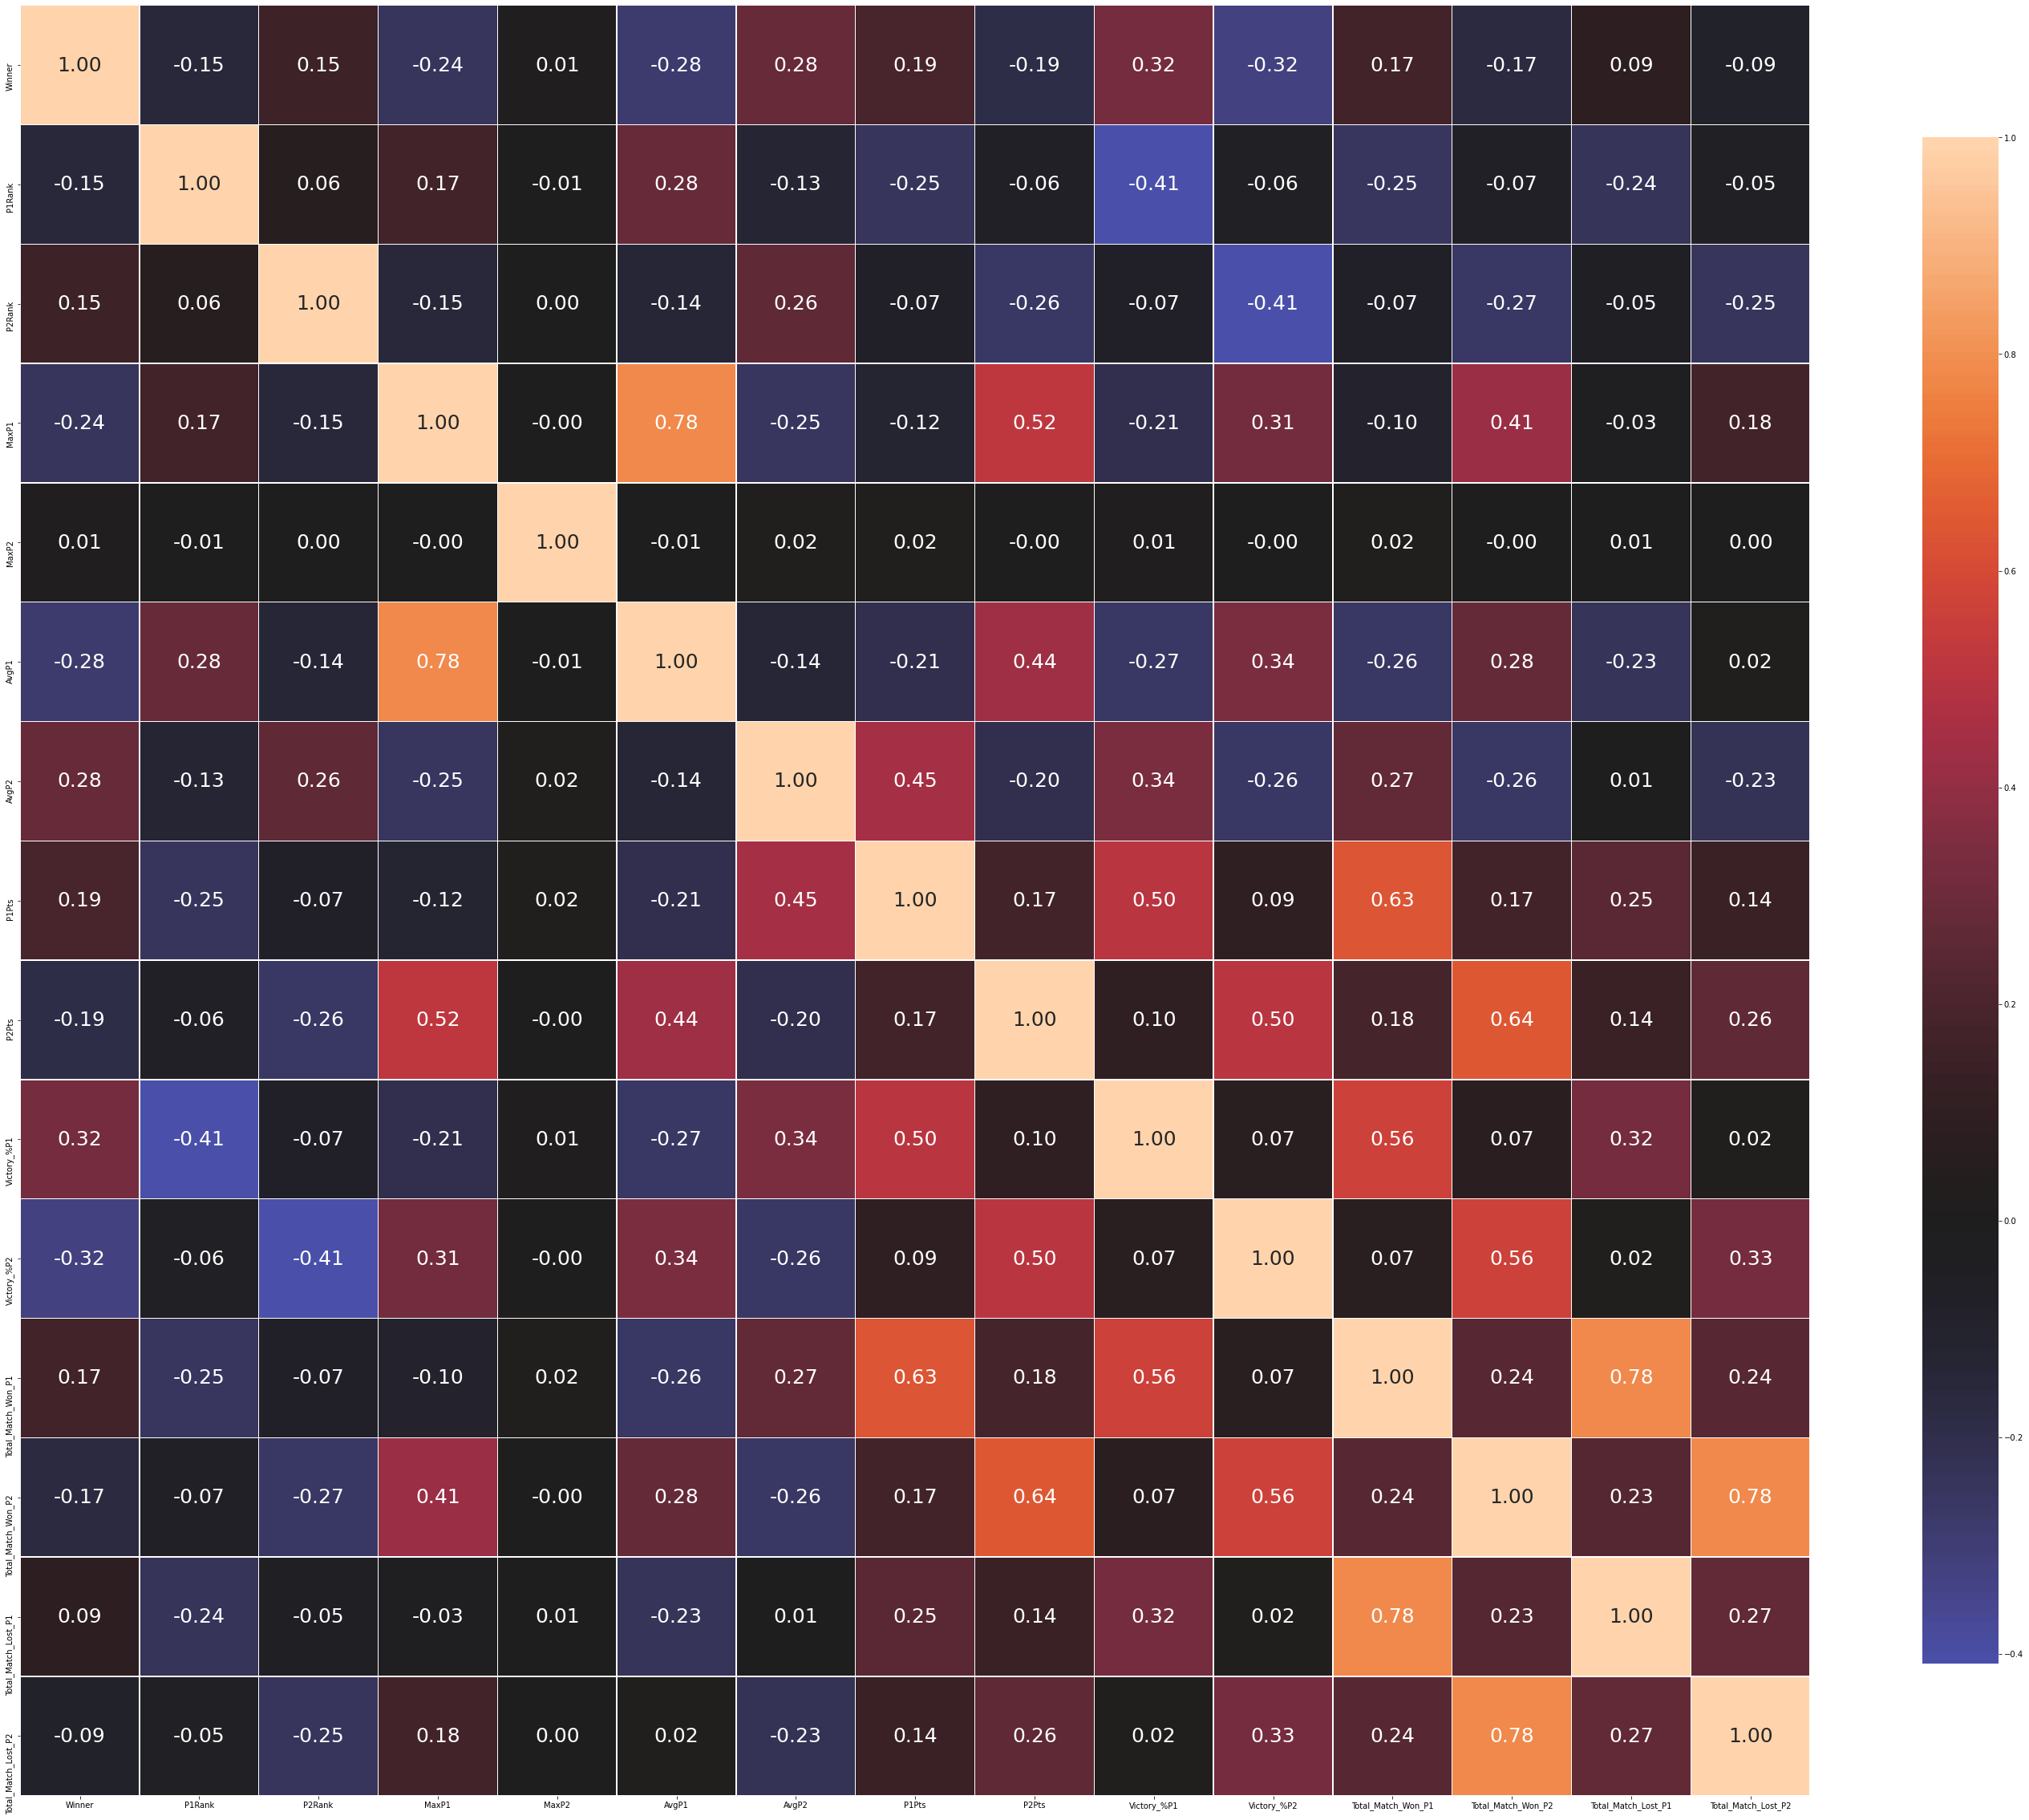


 The correlation heatmap shows that the selected columns are more relevent than the given ones when opening the dataframe at first to predict the winner column.

 Identifying the most promising model with KFold cross-validation 


 Training a LogisticRegression.
F1 score and accuracy score for training set: 0.7180, 0.7198.
F1 score and accuracy score for test set: 0.7191, 0.7227.

 Training a LogisticRegression.
F1 score and accuracy score for training set: 0.7198, 0.7212.
F1 score and accuracy score for test set: 0.7130, 0.7149.

 Training a LogisticRegression.
F1 score and accuracy score for training set: 0.7181, 0.7201.
F1 score and accuracy score for test set: 0.7183, 0.7196.

 Training a LogisticRegression.
F1 score and accuracy score for training set: 0.7173, 0.7182.
F1 score and accuracy score for test set: 0.7233, 0.7263.

 Training a LogisticRegression.
F1 score and accuracy score for training set: 0.7188, 0.7212.
F1 score and accuracy score for test set: 0.7151, 0.7135.

 Tr

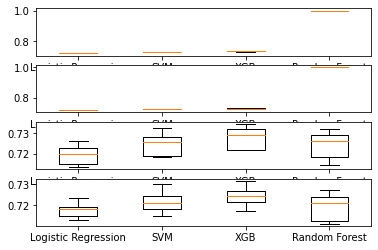

  0%|          | 0/5 [00:00<?, ?it/s]


 Optimizing the most promising model 




 20%|██        | 1/5 [00:54<03:39, 54.95s/it]


 F1 score and accuracy score for training set: 0.7676 , 0.7717.
F1 score and accuracy score for test set: 0.7497 , 0.7504.



 40%|████      | 2/5 [01:58<02:52, 57.60s/it]


 F1 score and accuracy score for training set: 0.7719 , 0.7760.
F1 score and accuracy score for test set: 0.7515 , 0.7516.

 F1 score and accuracy score for training set: 0.7756 , 0.7796.



 60%|██████    | 3/5 [03:11<02:04, 62.25s/it]

F1 score and accuracy score for test set: 0.7535 , 0.7533.

 F1 score and accuracy score for training set: 0.7815 , 0.7853.



 80%|████████  | 4/5 [04:34<01:08, 68.39s/it]

F1 score and accuracy score for test set: 0.7553 , 0.7552.

 F1 score and accuracy score for training set: 0.7842 , 0.7880.



  0%|          | 0/5 [00:00<?, ?it/s]

F1 score and accuracy score for test set: 0.7545 , 0.7544.



 20%|██        | 1/5 [01:00<04:00, 60.25s/it]


 F1 score and accuracy score for training set: 0.7691 , 0.7732.
F1 score and accuracy score for test set: 0.7499 , 0.7499.



 40%|████      | 2/5 [02:10<03:10, 63.37s/it]


 F1 score and accuracy score for training set: 0.7755 , 0.7797.
F1 score and accuracy score for test set: 0.7523 , 0.7526.

 F1 score and accuracy score for training set: 0.7808 , 0.7848.



 60%|██████    | 3/5 [03:31<02:17, 68.57s/it]

F1 score and accuracy score for test set: 0.7544 , 0.7545.

 F1 score and accuracy score for training set: 0.7844 , 0.7880.



 80%|████████  | 4/5 [05:01<01:14, 74.99s/it]

F1 score and accuracy score for test set: 0.7551 , 0.7552.

 F1 score and accuracy score for training set: 0.7876 , 0.7912.



  0%|          | 0/5 [00:00<?, ?it/s]

F1 score and accuracy score for test set: 0.7568 , 0.7569.



 20%|██        | 1/5 [01:05<04:21, 65.42s/it]


 F1 score and accuracy score for training set: 0.7697 , 0.7740.
F1 score and accuracy score for test set: 0.7502 , 0.7504.



 40%|████      | 2/5 [02:22<03:26, 68.79s/it]


 F1 score and accuracy score for training set: 0.7744 , 0.7783.
F1 score and accuracy score for test set: 0.7534 , 0.7535.

 F1 score and accuracy score for training set: 0.7794 , 0.7834.



 60%|██████    | 3/5 [03:49<02:28, 74.26s/it]

F1 score and accuracy score for test set: 0.7569 , 0.7571.

 F1 score and accuracy score for training set: 0.7845 , 0.7882.



 80%|████████  | 4/5 [05:26<01:21, 81.30s/it]

F1 score and accuracy score for test set: 0.7583 , 0.7581.

 F1 score and accuracy score for training set: 0.7890 , 0.7927.



100%|██████████| 3/3 [20:02<00:00, 400.77s/it]

F1 score and accuracy score for test set: 0.7560 , 0.7564.

 Predicting the winner of the 2017 matches with the optimized model 


 Best model saved, f1 : 0.7583, acc : 0.7581 

Best hyper-parameters tuned : {'learning_rate': [0.1], 'n_estimators': [450], 'max_depth': [4], 'min_child_weight': [3], 'gamma': [1], 'subsample': [0.8], 'colsample_bytree': [0.5], 'scale_pos_weight': [1], 'reg_alpha': [1e-05]} 

F1 score and accuracy score for 2017 dataset: 0.6925 , 0.6994.


Total time = 4170.884641885757


In [ ]:
def main():

    """
    Predicts the results of 2017 for the WTA and ATP datasets.

    It is possible to directly import the preprocessed files and run only the learning part.
    To do so, just uncomment the two imports and "atp(df_atp, atp_winner)" and
    comment "atp(df_atp)".
    """

    # importing datasets
    # df_wta = pd.read_csv("wta.csv")
    df_atp = pd.read_csv("atp.csv")
    # alternatively, getting them directly from the "Download the dataset" cell
    # is also possible

    # to import already preprocessed files and execute only the learning
    # df_atp = pd.read_csv("atp_preprocessed.csv")
    # atp_winner = pd.read_csv("atp_winner.csv")
    # atp(df_atp, atp_winner)
    
    atp(df_atp)
    # wta(df_wta)

main()

## Conclusion

I found out that xgboost was the best suiting model to predict the winner of the tennis matches using the odds, the ranks, the percentages of victory and the total number of matches played by each player.
<br>
It seemed that dropping year 2018's matches also helped a little to get better accuracy and f1 as well as dropping the dates that were in a one-hot column fashion. Also, dropping columns like 'Series', 'Tournament' and so didn't really affect the prediction results but increased the time to fit as well as the difficulty to generalize.
<br>
The final f1 and accuracy scores are close to 0.7.

## Comments

There must be an easier way to do the prediction rather than converting everything to player 1 and player 2 but I couldn't think of something else...
<br>
The code also works for the WTA dataset, you just have to uncomment the wta() function call in the main function.